# **Data science 2- Homework 2 solution**
***

In [214]:
# imports
import pandas as pd
import unicodeit
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import display,Markdown
import statsmodels.api as sm
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN


In [215]:
# define random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)

## **1. Load the "Individual household electric power consumption" dataset** 
***

First, we will load the dataset and observe it:

In [216]:
# first define datatypes for the columns
dtypes = {'Date': str,
          'Time': str,
          'Global_active_power': float,
          'Global_reactive_power': float,
          'Voltage': float,
          'Global_intensity': float,
          'Sub_metering_1': float,
          'Sub_metering_2': float,
          'Sub_metering_3': float}

'''
fetch the dataset (acknowledging that the seperator is ';' and missing values are marked as '?'
'''

file_path = 'household_power_consumption.txt'
power_consumption_df = pd.read_csv(file_path, sep=';',dtype=dtypes,na_values='?')
power_consumption_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


We can see that we have 9 features:
* Date
* Time
* Global_active_power
* Global_reactive_power
* Voltage
* Global_intensity
* Sub_metering_1
* Sub_metering_2
* Sub_metering_3

However, our target (active energy consumed every minute) is  not specified in the dataset. we will define "Global_active_power" as our target. Also, we would like to combine date and time to a one feature called: "datetime".

In [217]:
# combine date and time into datetime
power_consumption_df['Datetime'] = pd.to_datetime(power_consumption_df['Date'] + ' ' + power_consumption_df['Time'], format='%d/%m/%Y %H:%M:%S')

# Set the datetime column as index
power_consumption_df.set_index('Datetime', inplace=True)

# Drop the original Date and TIme columns
power_consumption_df.drop(columns=['Date', 'Time'], inplace=True)
power_consumption_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


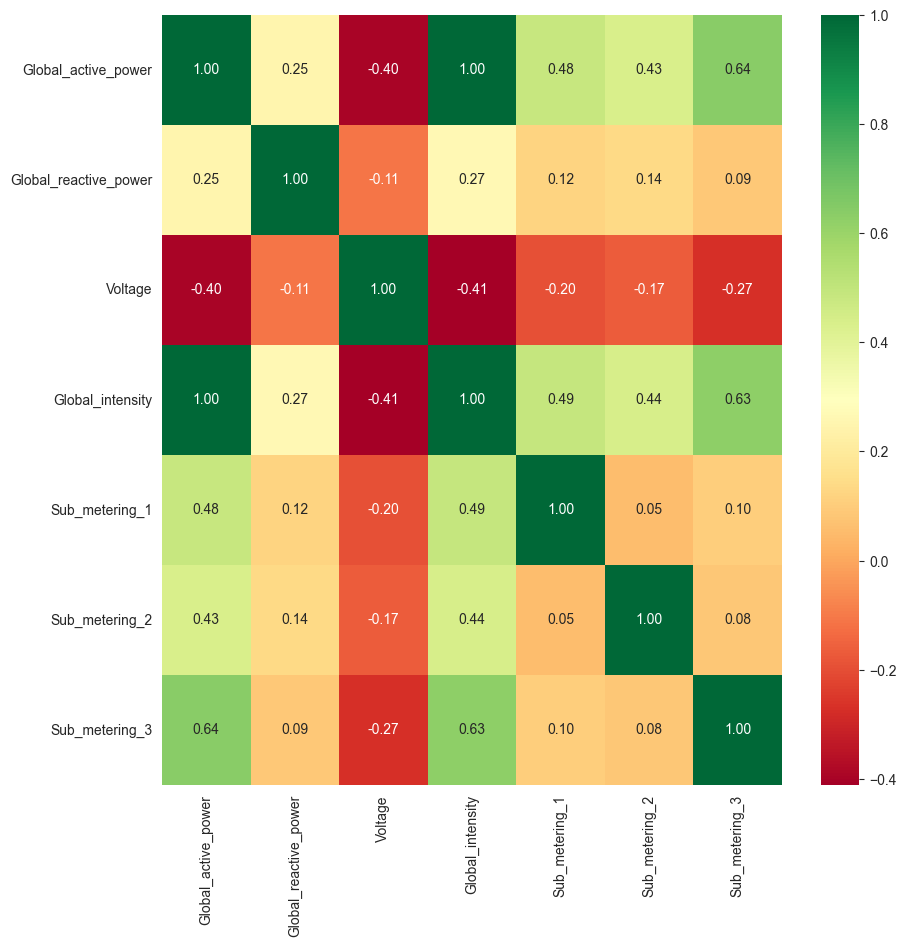

In [218]:
# Create a correlation plot to find the correlation between columns
plt.figure(figsize=(10, 10)) 
sns.heatmap(power_consumption_df.corr(method='pearson'),  
            annot=True,  
            cmap='RdYlGn',  
            fmt='.2f')  
plt.show()

After analyze have correlation between Global active power and Sub_metering_1, Sub_metering_2, Sub_metering_3, and Global intensity,


## 2. **EDA**
***

### **Visualize time series trends**
*** 

We will first view the time series trends

C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


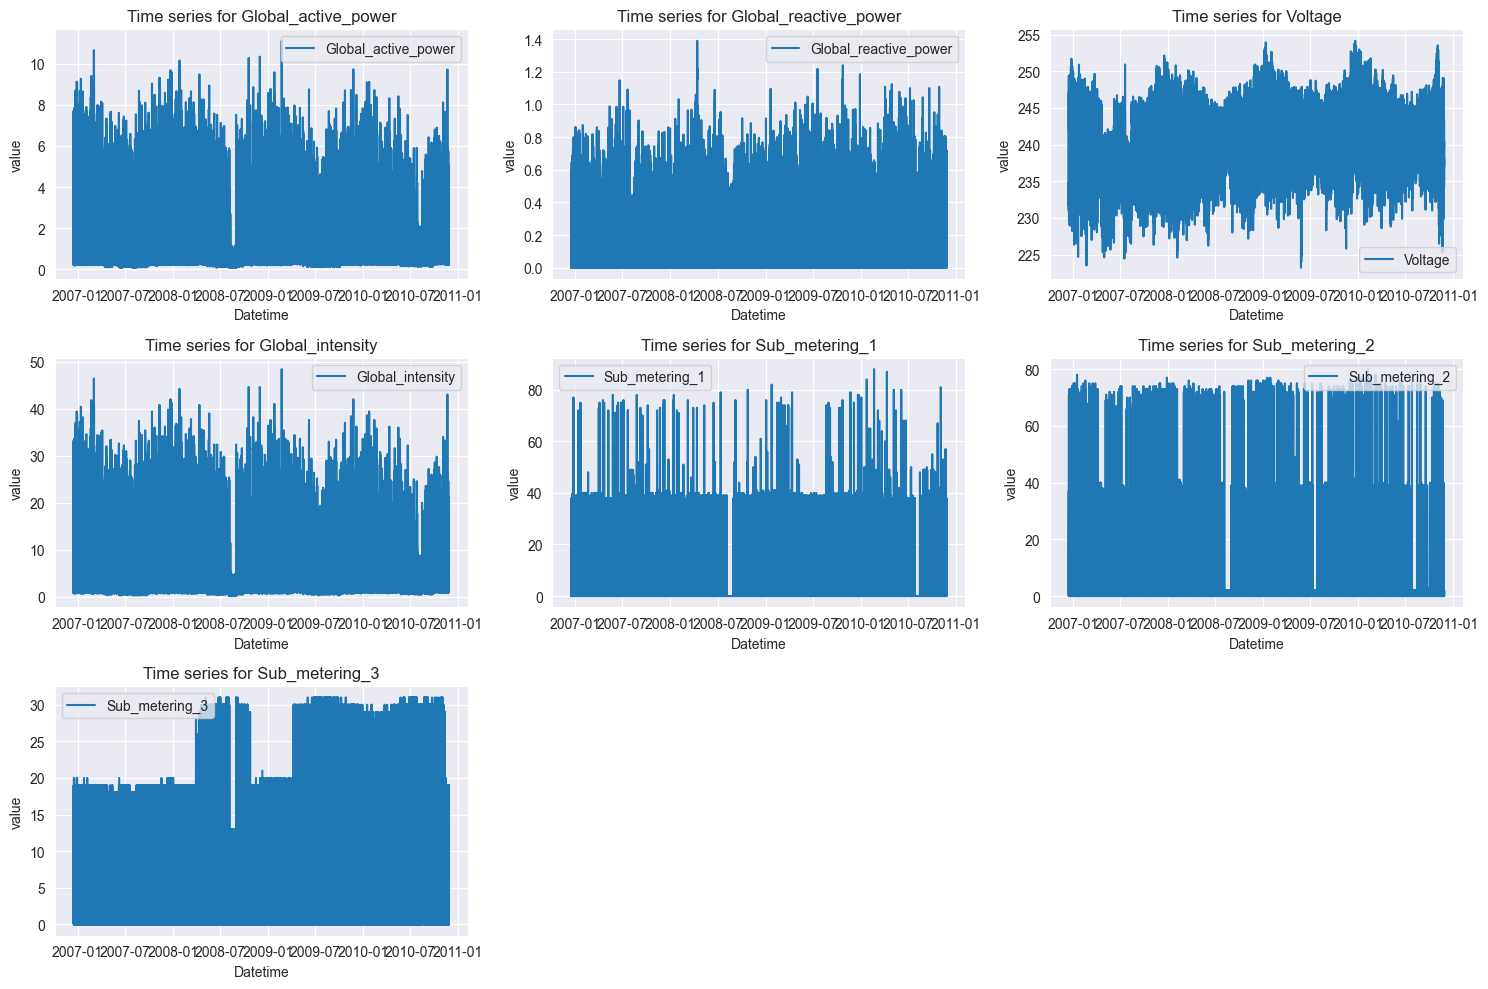

In [72]:
def visualize_time_trends(data,columns_to_omit=None,resample=None):
    num_plots = len(data.columns) - len(columns_to_omit) if columns_to_omit is not None else len(data.columns)
    num_rows = num_cols = math.ceil(math.sqrt(num_plots))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,10))
    if columns_to_omit is  None:
        columns_to_omit = []

    i = j = 0

    for column in data.columns:
        if column not in columns_to_omit:
            if resample is None:
                axes[i, j].plot(data[column], label=column)

            else:
                axes[i, j].plot(data[column].resample(resample).mean(), label=column)

            axes[i, j].set_title(f'Time series for {column}')
            axes[i, j].set_xlabel('Datetime')
            axes[i, j].set_ylabel(f"value")
            axes[i,j].legend()
            j += 1

            if j == num_cols:
                j = 0
                i += 1

    if math.sqrt(num_plots) < num_cols:
        remainder = (num_cols ** 2) % num_plots
        for i in range(1, remainder + 1, 1):
            axes[-1,-1 * i].axis('off') # hide the last plots

    plt.tight_layout()
    plt.grid(True)
    plt.show()

visualize_time_trends(power_consumption_df)

let's try to resample the data to get some better visualization:


In [220]:
# visualize_time_trends(data=power_consumption_df,resample='D')   # daily resampling

In [221]:
# visualize_time_trends(data=power_consumption_df,resample='W')   # weekly resampling

In [222]:
# visualize_time_trends(data=power_consumption_df,resample='ME')   # monthly resampling

In [223]:
# visualize_time_trends(data=power_consumption_df,resample='YE')   # annual resampling

### **Check for seasonality and cyclical patterns**
***

According to the time series trends we can say the following:
1. **Global Active Power**

    * **Seasonality:** It seems like there are strong seasonal patterns with regular peaks and troughs (best appeared in the monthly resampling). This phenomenon could be explained by high power consumption during certain times of the year (for example, hot summer days)
         
   * **Cyclical Patterns:** There may be some longer-term trends, but they are overshadowed and difficult to isolate from the clear seasonal patterns without further analysis.

2. **Global reactive power**
    * **Seasonality:** Similar to Global Active Power, we can see a strong seasonal pattern (which makes sense, since the reactive power are the losses from the electrical appliances of the consumer, so they should have the same seasonality as the active power)
      
    * **Cyclical Patterns:** The same as the active power - longer term trends are less apparent, since there is a strong seasonal pattern.

3. **Voltage** 
    * **Seasonality:** The voltage shows less clear seasonal patterns (it doesn't seem to have a constant period) compared to power consumption, though there are still some periodic fluctuations (it seems clearer in the weekly or monthly resampling)
      
    * **Cyclical Patterns:** If there are any cyclical patterns in the voltage, they are not very prominent.

4. **Global Intensity**
    * **Seasonality:** There is a clear seasonal pattern, with regular fluctuations which again could be explained by periods of higher electricity demand.
      
    * **Cyclical Patterns:** Similar to the Global Active Power, the cyclical trends are less evident due to the dominant seasonal patterns.

5. **Sub Metering 1,2, and 3:** 
    * **Seasonality:** Each sub metering shows distinct seasonal patterns, likely corresponding to specific appliances that have different regular usage cycles.
      
    * **Cyclical Patterns:** Less apparent, as the data is dominated by strong seasonal patterns.



**Conclusion**

This dataset exhibits strong seasonal patterns across most of the features, as well as the target variable (Global_active_power). The seasonal patterns are consistent and predictable, and most likely correspond to higher and lower power demand during different periods of the year.

Cyclical patterns in this dataset are harder to distinguish from the seasonal ones, due to the dominance of the seasonal patterns.

### **Analyze distribution of power consumption**
***

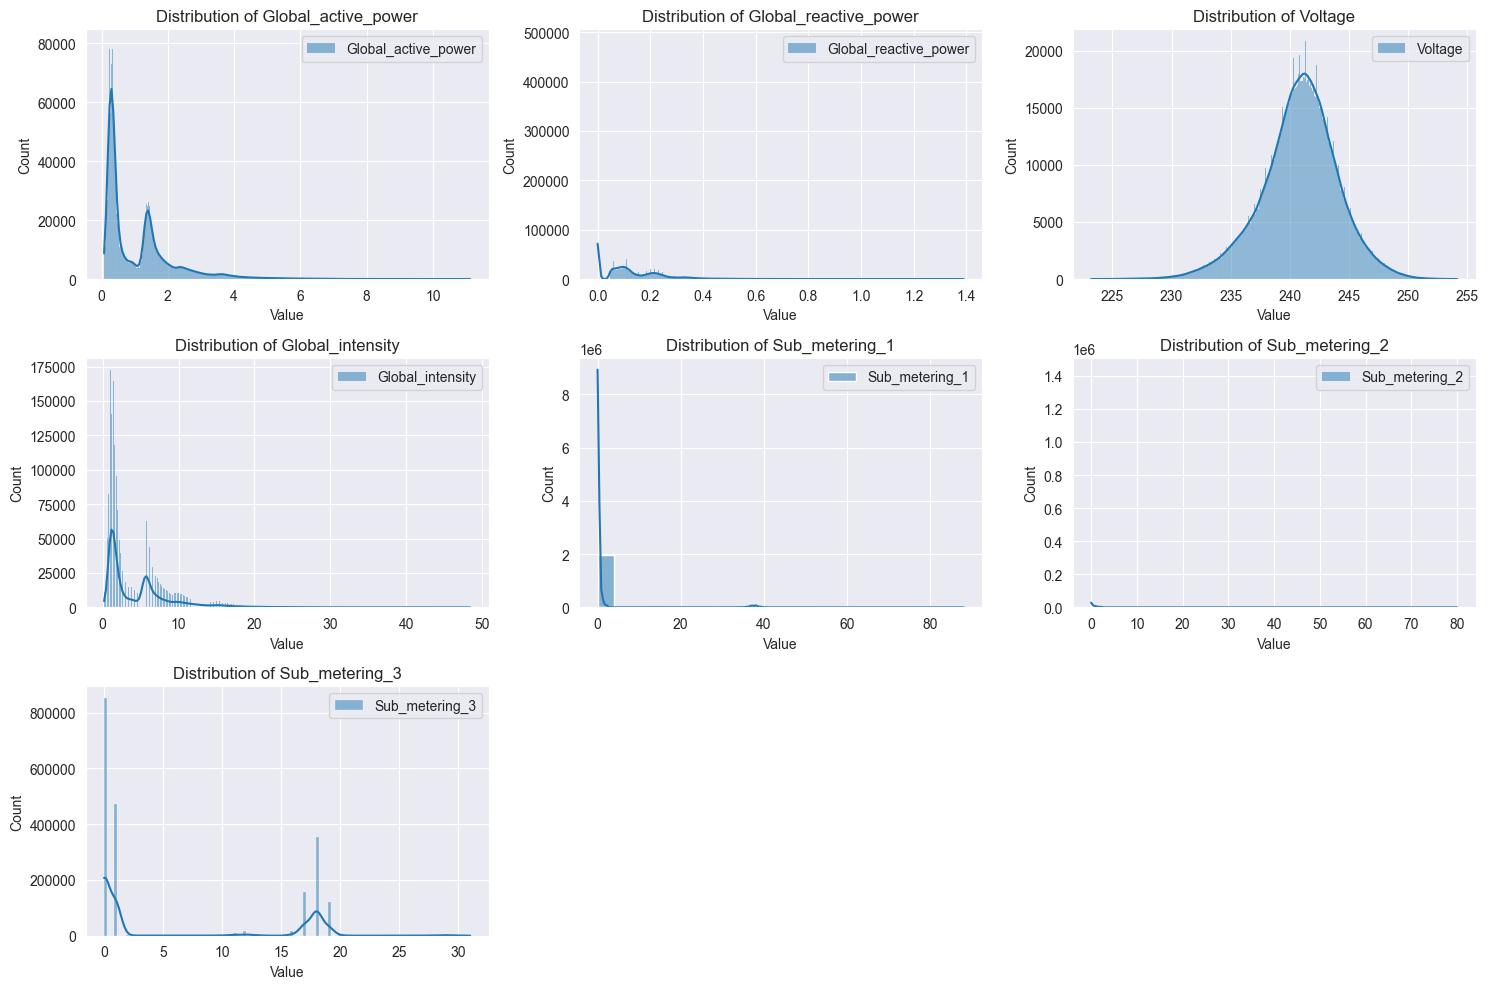

In [73]:
def visualize_distributions(data,columns_to_omit=None):
    num_plots = len(data.columns) - len(columns_to_omit) if columns_to_omit is not None else len(data.columns)
    num_rows = num_cols = math.ceil(math.sqrt(num_plots))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,10))

    if columns_to_omit is  None:
        columns_to_omit = []

    i = j = 0

    for column in data.columns:
        if column not in columns_to_omit:
            sns.histplot(x=data[column], label=column,kde=True,ax=axes[i,j])
            axes[i, j].set_title(f'Distribution of {column}')
            axes[i, j].set_xlabel('Value')
            axes[i, j].set_ylabel("Count")
            axes[i,j].legend()
            j += 1

            if j == num_cols:
                j = 0
                i += 1

    if math.sqrt(num_plots) < num_cols:
        remainder = (num_cols ** 2) % num_plots
        for i in range(1, remainder + 1, 1):
            axes[-1,-1 * i].axis('off') # hide the last plots

    plt.tight_layout()
    plt.grid(True)
    plt.show()

visualize_distributions(data=power_consumption_df)

From the distributions we can draw the following conclusions:
* The Global Active power seems to be consisted of two different normal distributions, one centered near 0, and the other centered at approximately 1.7. That could imply some different seasonal patterns within the year, one with lower power consumption, and the other - with a higher one.

* The Global reactive power seems to be less sparse, and will most likely be near 0. It implies that the electricity network is efficient and doesn't suffer from many losses :) .

* The voltage is clearly normally distributed with a mean around 240V (which makes sense since it's a French household). The voltage consumption is sparse, and that could be explained by different voltage consumptions from different appliances.

* Just like Global Active Power, the Global Intensity also seems to be consisted of two normal distributions which can imply different seasonal patterns - one centered at approximately 0 and one centered at approximately 5 .

* Sub Metering 1 seems to be most likely near 0. It could imply that this type of appliance consume much less energy.
* Sub metering 2 seems to have much less value counts... It could imply that this column has missing values (we will check that right in the next cell).

* Sub Metering 3 seems to be more distributed. It has some peaks between 0 and 2 (most of the values lie there) but it also has a decent amount of values between 15-20. It could be interpreted either as a high power consumption period, or as outliers.

### **Identify and handle missing values and outliers**
***

First, let's check for missing values and where they lie (**Note:** we have already noticed that missing values are marked as '?', and made Pandas interpret that as N.A.):

In [225]:
display(power_consumption_df.isna().sum())
display(Markdown(f'##### {power_consumption_df.isna().sum().iloc[0]/ power_consumption_df.shape[0] * 100}% of the data is missing'))

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

##### 1.2518437457686005% of the data is missing

We can see that all the measurements columns has missing values, all with the same amount of missing values (25979 which is approximately 1.25% of the data, just as the dataset documentation described).

Now let's check for outliers:

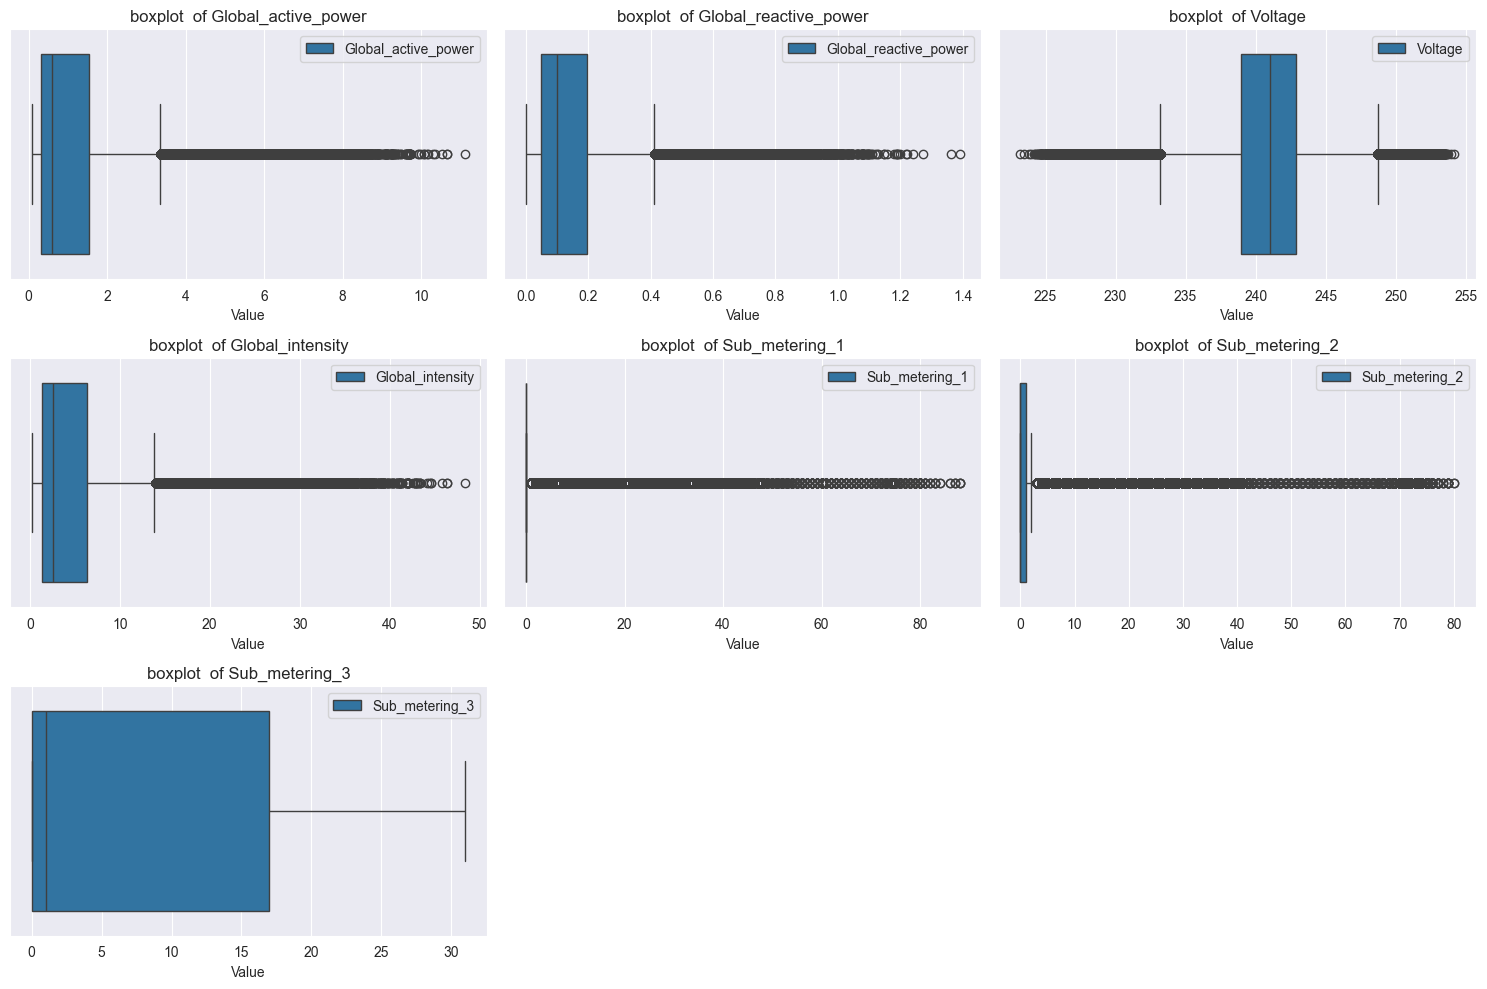

In [74]:
def visualize_boxplots(data,columns_to_omit=None):
    num_plots = len(data.columns) - len(columns_to_omit) if columns_to_omit is not None else len(data.columns)
    num_rows = num_cols = math.ceil(math.sqrt(num_plots))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,10))

    if columns_to_omit is  None:
        columns_to_omit = []

    i = j = 0

    for column in data.columns:
        if column not in columns_to_omit:
            sns.boxplot(x=data[column], label=column,ax=axes[i,j])
            axes[i, j].set_title(f'boxplot  of {column}')
            axes[i, j].set_xlabel('Value')
            axes[i,j].legend()
            j += 1

            if j == num_cols:
                j = 0
                i += 1

    if math.sqrt(num_plots) < num_cols:
        remainder = (num_cols ** 2) % num_plots
        for i in range(1, remainder + 1, 1):
            axes[-1,-1 * i].axis('off') # hide the last plots

    plt.tight_layout()
    plt.grid(True)
    plt.show()

visualize_boxplots(data=power_consumption_df)

From the boxplots, we can see that the dataset has a lot of outliers. However, that could be explained by different seasonal patterns of power consumption within the year. Therefore, we wouldn't like to manipulate these outliers, on the contrary - we would like to use them in order to predict high / low power consumptions on certain periods during the year.

So, let's first handle the missing values. We will impute them using forward fill method. This method  will fill the missing values with the last observed value.  We will forward fill all the missing values:

In [227]:
power_consumption_df_no_missing = power_consumption_df.copy()

for _column in power_consumption_df_no_missing.columns:
    # forward fill the column
    power_consumption_df_no_missing[_column] = power_consumption_df_no_missing[_column].ffill() 

# check for the existence of missing values again
power_consumption_df_no_missing.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Now that we have filled the missing values and re-calculated our target. let's deal with the outliers. let's make a seasonal decomposition (for example, let's do that to the global_active_power):

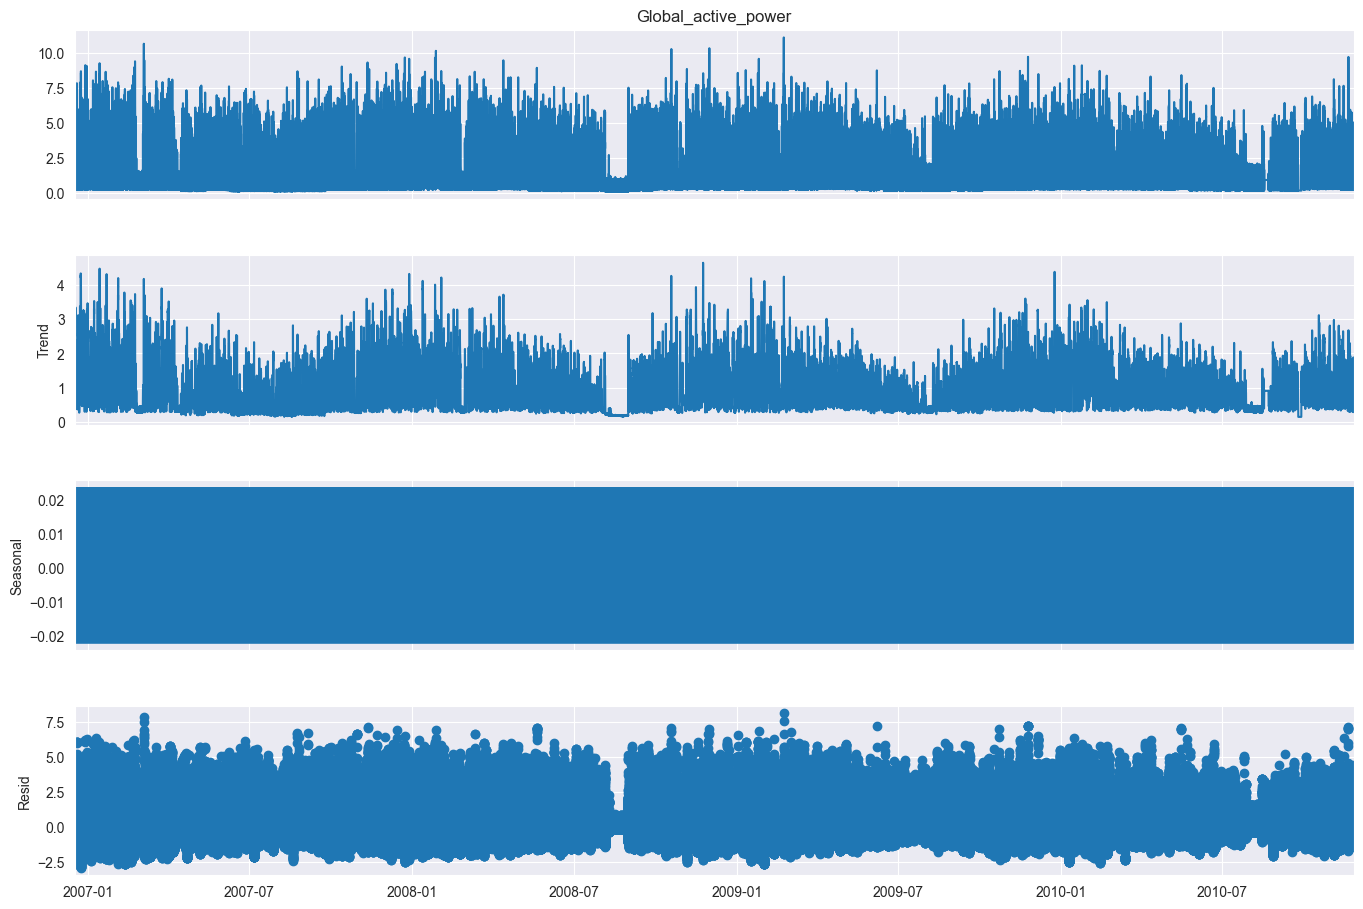

In [75]:
decomposition = sm.tsa.seasonal_decompose(power_consumption_df_no_missing['Global_active_power'],model='additive',period=365)
fig1 = decomposition.plot()
fig1.set_size_inches((15,10))
plt.show()

This decomposition consists of the following:
* **Observed:** The time series as it is (the actual data)
* **Trend:** reveals the long-term increase/decrease in the global_active_power consumption.
* **Seasonal:** The seasonal plot shows recurring patterns, for example: higher consumption during certain times of the month.
* **Residual:** The residual plot displays the noise or irregularities in the data (so we can use that in order to identify the outliers). We wil define an outlier as:
$outlier = resid.mean() \pm 3*resid.std()$
* We will check outliers for our target variable to see if it makes sense (for example - higher power consumption during summer). 

In [229]:
def check_for_outliers(time_series,period,number_of_stds):
    seasonal_decomposition = sm.tsa.seasonal_decompose(time_series,model='additive',period=period)
    residuals = seasonal_decomposition.resid
    outliers_high = residuals[(residuals > residuals.mean() + number_of_stds * residuals.std())]
    outliers_low = residuals[(residuals < residuals.mean() - number_of_stds * residuals.std())]
    return outliers_low.index, outliers_high.index
(low_outliers_dates, high_outliers_dates) = check_for_outliers(time_series=power_consumption_df_no_missing['Global_active_power'],period=365,number_of_stds=3)
display(Markdown(f'##### low_power consumption dates are: {low_outliers_dates}'))
display(Markdown(f'##### high_power consumption dates are: {high_outliers_dates}'))

##### low_power consumption dates are: DatetimeIndex(['2006-12-16 22:31:00', '2006-12-16 22:36:00',
               '2006-12-16 22:41:00', '2006-12-16 22:47:00',
               '2006-12-16 23:03:00', '2006-12-23 00:08:00',
               '2006-12-23 00:13:00', '2006-12-23 05:30:00',
               '2006-12-23 05:35:00', '2006-12-23 05:40:00',
               ...
               '2010-03-13 17:02:00', '2010-03-13 17:03:00',
               '2010-03-13 17:04:00', '2010-03-13 17:05:00',
               '2010-03-13 17:06:00', '2010-03-13 17:07:00',
               '2010-03-13 17:08:00', '2010-03-13 17:09:00',
               '2010-03-13 17:10:00', '2010-03-13 17:11:00'],
              dtype='datetime64[ns]', name='Datetime', length=349, freq=None)

##### high_power consumption dates are: DatetimeIndex(['2006-12-17 01:04:00', '2006-12-17 01:05:00',
               '2006-12-17 01:08:00', '2006-12-17 01:09:00',
               '2006-12-17 01:10:00', '2006-12-17 01:13:00',
               '2006-12-17 01:14:00', '2006-12-17 01:15:00',
               '2006-12-17 01:19:00', '2006-12-17 01:20:00',
               ...
               '2010-11-26 07:32:00', '2010-11-26 07:33:00',
               '2010-11-26 07:34:00', '2010-11-26 07:35:00',
               '2010-11-26 07:36:00', '2010-11-26 07:37:00',
               '2010-11-26 07:38:00', '2010-11-26 07:39:00',
               '2010-11-26 07:40:00', '2010-11-26 07:41:00'],
              dtype='datetime64[ns]', name='Datetime', length=41770, freq=None)

let's see what percentage of the data are these outliers before we make a decision:

In [230]:
display(Markdown(f'##### {(len(low_outliers_dates) + len(high_outliers_dates)) / power_consumption_df_no_missing.shape[0] * 100}% of the data is considered outliers'))

##### 2.029577994843053% of the data is considered outliers

since only 2% of the data is considered outliers, we will decide to drop them:

In [231]:
power_consumption_df_no_missing_no_outliers = power_consumption_df_no_missing.copy()
outliers_to_drop = low_outliers_dates.union(high_outliers_dates)
power_consumption_df_no_missing_no_outliers.drop(outliers_to_drop,inplace=True)
display(power_consumption_df_no_missing_no_outliers)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


## 3. **Implement a linear regression model**
***

### **Create lag variables**
***

since we are trying to predict Global_active_power for the last 3 time periods, and in reality we won't have any knowledge besides past knowledge we will create 3 lag variables for each feature (including the Global_active_Power itself):

In [232]:
def create_lag_variables_and_fill(dataframe,num_of_lags,columns_to_lag):
    returned_df = dataframe.copy()
    for column in columns_to_lag:
        for i in range(1, num_of_lags + 1 , 1):
            returned_df[f'{column}_lag_{i}'] = returned_df[column].shift(i)
            # backward fill the missing values
            returned_df[f'{column}_lag_{i}'] = returned_df[f'{column}_lag_{i}'].fillna(returned_df[f'{column}_lag_{i}'].to_numpy()[i])
    return returned_df


power_consumption_df_no_missing_no_outliers_with_lags = create_lag_variables_and_fill(power_consumption_df_no_missing_no_outliers,3,power_consumption_df_no_missing_no_outliers.columns)
display(power_consumption_df_no_missing_no_outliers_with_lags)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_lag_1,Global_active_power_lag_2,Global_active_power_lag_3,...,Global_intensity_lag_3,Sub_metering_1_lag_1,Sub_metering_1_lag_2,Sub_metering_1_lag_3,Sub_metering_2_lag_1,Sub_metering_2_lag_2,Sub_metering_2_lag_3,Sub_metering_3_lag_1,Sub_metering_3_lag_2,Sub_metering_3_lag_3
Datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,4.216,4.216,4.216,...,18.4,0.0,0.0,0.0,1.0,1.0,1.0,17.0,17.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,4.216,4.216,4.216,...,18.4,0.0,0.0,0.0,1.0,1.0,1.0,17.0,17.0,17.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5.360,4.216,4.216,...,18.4,0.0,0.0,0.0,1.0,1.0,1.0,16.0,17.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,5.374,5.360,4.216,...,18.4,0.0,0.0,0.0,2.0,1.0,1.0,17.0,16.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,5.388,5.374,5.360,...,23.0,0.0,0.0,0.0,1.0,2.0,1.0,17.0,17.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.946,0.942,0.946,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.946,0.946,0.942,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.944,0.946,0.946,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The shifting process, creates missing values, corresponding to the shifting amount (for example lag_1 creates 1 Nan at the beginning, lag_2 creates two and so on...). We made backward fill in order to deal with that.

### **Create features and target**
***

We will use past knowledge (lag variables) as features, since in reality in order to predict Global_active_power we won't have the current values, we will lag all the features 3 samples backward:

In [233]:
features_list = [column for column in power_consumption_df_no_missing_no_outliers_with_lags.columns if 'lag' in column]
x_linear = power_consumption_df_no_missing_no_outliers_with_lags[features_list]
y_linear = power_consumption_df_no_missing_no_outliers_with_lags['Global_active_power']
display(Markdown(f'##### Features: \n')) 
display(x_linear)
display(Markdown(f'##### Target: \n'))
display(y_linear)

##### Features: 


,Global_active_power_lag_1,Global_active_power_lag_2,Global_active_power_lag_3,Global_reactive_power_lag_1,Global_reactive_power_lag_2,Global_reactive_power_lag_3,Voltage_lag_1,Voltage_lag_2,Voltage_lag_3,Global_intensity_lag_1,...,Global_intensity_lag_3,Sub_metering_1_lag_1,Sub_metering_1_lag_2,Sub_metering_1_lag_3,Sub_metering_2_lag_1,Sub_metering_2_lag_2,Sub_metering_2_lag_3,Sub_metering_3_lag_1,Sub_metering_3_lag_2,Sub_metering_3_lag_3
Datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,4.216,4.216,0.418,0.418,0.418,234.84,234.84,234.84,18.4,...,18.4,0.0,0.0,0.0,1.0,1.0,1.0,17.0,17.0,17.0
2006-12-16 17:25:00,4.216,4.216,4.216,0.418,0.418,0.418,234.84,234.84,234.84,18.4,...,18.4,0.0,0.0,0.0,1.0,1.0,1.0,17.0,17.0,17.0
2006-12-16 17:26:00,5.360,4.216,4.216,0.436,0.418,0.418,233.63,234.84,234.84,23.0,...,18.4,0.0,0.0,0.0,1.0,1.0,1.0,16.0,17.0,17.0
2006-12-16 17:27:00,5.374,5.360,4.216,0.498,0.436,0.418,233.29,233.63,234.84,23.0,...,18.4,0.0,0.0,0.0,2.0,1.0,1.0,17.0,16.0,17.0
2006-12-16 17:28:00,5.388,5.374,5.360,0.502,0.498,0.436,233.74,233.29,233.63,23.0,...,23.0,0.0,0.0,0.0,1.0,2.0,1.0,17.0,17.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.942,0.946,0.000,0.000,0.000,240.33,239.41,239.74,4.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.946,0.946,0.942,0.000,0.000,0.000,240.43,240.33,239.41,4.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.944,0.946,0.946,0.000,0.000,0.000,240.00,240.43,240.33,4.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Target: 


Datetime
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
                       ...  
2010-11-26 20:58:00    0.946
2010-11-26 20:59:00    0.944
2010-11-26 21:00:00    0.938
2010-11-26 21:01:00    0.934
2010-11-26 21:02:00    0.932
Name: Global_active_power, Length: 2033140, dtype: float64


### **Split the data into train and test**
***

First, resample the data for faster performance:

In [234]:
def resample_by_period(dataframe, period):
    if isinstance(dataframe, pd.DataFrame):
        resampled_dataframe = pd.DataFrame(columns=dataframe.columns)
    else:
        resampled_dataframe = pd.DataFrame(columns=dataframe.index)
    if isinstance(dataframe,pd.DataFrame):
        for column in dataframe.columns:
            resampled_dataframe[column] = dataframe[column].resample(period).mean().copy()
    else:
        resampled_dataframe = dataframe.resample(period).mean().copy()
        
    return resampled_dataframe

x_linear_resampled = resample_by_period(x_linear, 'ME')
y_linear_resampled = resample_by_period(y_linear, 'ME')
display(Markdown(f'##### Resampled Features: \n')) 
display(x_linear_resampled)
display(Markdown(f'##### Resampled Target: \n'))
display(y_linear_resampled)

##### Resampled Features: 


,Global_active_power_lag_1,Global_active_power_lag_2,Global_active_power_lag_3,Global_reactive_power_lag_1,Global_reactive_power_lag_2,Global_reactive_power_lag_3,Voltage_lag_1,Voltage_lag_2,Voltage_lag_3,Global_intensity_lag_1,...,Global_intensity_lag_3,Sub_metering_1_lag_1,Sub_metering_1_lag_2,Sub_metering_1_lag_3,Sub_metering_2_lag_1,Sub_metering_2_lag_2,Sub_metering_2_lag_3,Sub_metering_3_lag_1,Sub_metering_3_lag_2,Sub_metering_3_lag_3
Datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-31,1.792184,1.792257,1.792334,0.129921,0.129931,0.129944,241.603473,241.603140,241.602775,7.564663,...,7.565377,0.681786,0.681786,0.681786,1.612174,1.612221,1.612268,7.268531,7.269330,7.270129
2007-01-31,1.443022,1.443076,1.443128,0.130987,0.130989,0.130989,241.054885,241.054863,241.054864,6.105656,...,6.106088,0.933666,0.933666,0.933666,1.220791,1.220791,1.220791,7.197414,7.197414,7.197414
2007-02-28,1.296978,1.296981,1.296983,0.111452,0.111456,0.111459,240.648624,240.648598,240.648554,5.469684,...,5.469705,0.779660,0.779660,0.779660,1.115502,1.115502,1.115502,6.513344,6.513344,6.513344
2007-03-31,1.200846,1.200775,1.200703,0.112090,0.112085,0.112080,240.681992,240.682073,240.682163,5.069321,...,5.068730,0.872800,0.872777,0.872754,1.781840,1.781817,1.781771,6.289601,6.289209,6.288793
2007-04-30,0.789315,0.789385,0.789454,0.125225,0.125226,0.125228,239.201172,239.201215,239.201235,3.397753,...,3.398328,0.598031,0.598055,0.598078,0.666109,0.666133,0.666180,4.234046,4.234446,4.234870
2007-05-31,0.896979,0.896978,0.896977,0.113662,0.113661,0.113662,235.283864,235.283899,235.283954,3.912464,...,3.912451,1.110391,1.110391,1.110391,1.299057,1.299034,1.299034,4.956437,4.956437,4.956437
2007-06-30,0.747511,0.747458,0.747399,0.143984,0.143982,0.143978,238.963215,238.963169,238.963126,3.265253,...,3.264794,0.903634,0.903634,0.903634,1.278601,1.278625,1.278625,4.188926,4.188500,4.188075
2007-07-31,0.601334,0.601393,0.601456,0.126632,0.126639,0.126645,237.736103,237.736174,237.736252,2.664859,...,2.665370,0.559345,0.559345,0.559345,0.982535,0.982535,0.982535,3.298016,3.298427,3.298838
2007-08-31,0.692135,0.692118,0.692102,0.111303,0.111297,0.111291,238.004860,238.004727,238.004588,3.005451,...,3.005305,0.388902,0.388902,0.388902,0.829957,0.829911,0.829888,4.868758,4.868758,4.868758


##### Resampled Target: 


Datetime
2006-12-31    1.792110
2007-01-31    1.442969
2007-02-28    1.296975
2007-03-31    1.200927
2007-04-30    0.789236
2007-05-31    0.896981
2007-06-30    0.747561
2007-07-31    0.601278
2007-08-31    0.692151
2007-09-30    0.869282
2007-10-31    1.005680
2007-11-30    1.177371
2007-12-31    1.483371
2008-01-31    1.350805
2008-02-29    1.097545
2008-03-31    1.141800
2008-04-30    1.031503
2008-05-31    0.942980
2008-06-30    0.906079
2008-07-31    0.738335
2008-08-31    0.269107
2008-09-30    0.912023
2008-10-31    1.050134
2008-11-30    1.295686
2008-12-31    1.206652
2009-01-31    1.298818
2009-02-28    1.172914
2009-03-31    1.141665
2009-04-30    1.061955
2009-05-31    0.953551
2009-06-30    0.754357
2009-07-31    0.592075
2009-08-31    0.606555
2009-09-30    0.926177
2009-10-31    1.071071
2009-11-30    1.196393
2009-12-31    1.289138
2010-01-31    1.358349
2010-02-28    1.296086
2010-03-31    1.042422
2010-04-30    0.992568
2010-05-31    1.025733
2010-06-30    0.920090
20

In [235]:
# This will be used for all models
x_train_linear, x_test_linear, y_train_linear, y_test_linear = train_test_split(x_linear_resampled, y_linear_resampled, test_size=0.2, random_state=seed)

### **Train the model and make predictions**
*** 

In [236]:
def train_scale_and_predict(model_cls,x_train,y_train,x_test,scaler_cls):
    model_normalized = make_pipeline(scaler_cls(),model_cls())
    model_normalized.fit(x_train,y_train)
    y_pred = model_normalized.predict(x_test)
    return y_pred

lr_predicted = train_scale_and_predict(LinearRegression,x_train_linear,y_train_linear,x_test_linear,StandardScaler)
display(lr_predicted)

array([1.14166263, 0.99256775, 1.17291617, 0.70112038, 1.20664872,
       1.35834922, 1.48336961, 0.73833494, 0.78923585, 1.29881542])

## 4. **Evaluate the linear regression model**
***

In [237]:
def evaluate_model(y_true,y_pred,model_cls):
    results_df = pd.DataFrame({'Model_name': model_cls.__name__ ,'MAE': mean_absolute_error(y_true, y_pred), 'MSE': mean_squared_error(y_true, y_pred), 'RMSE': root_mean_squared_error(y_true, y_pred), unicodeit.replace('R^2'): r2_score(y_true, y_pred)}, index=[0])
    display(results_df)
    return results_df

lr_results = evaluate_model(y_test_linear,lr_predicted,LinearRegression)

,Model_name,MAE,MSE,RMSE,R²
0,LinearRegression,0.000001,3.533528e-12,0.000002,1.0


We can draw the following conclusions from these metrics:
* MAE, MSE and RMSE are extremely low (very close to 0), so this model predicts the  power in test set almost perfectly, with an extremely low error.
* Moreover - the $R^2$ is the highest possible (1.0), although this metric is not very suitable for multiple linear regression.

## 5. **RNN**
***

### **Preprocess data for RNN input**
***

we will create sequences from the data that will be used for the RNN network:

In [238]:
# # Create sequences of data for RNN input
# def create_sequences(data, seq_length, target_column):
#     xs = pd.DataFrame(columns=data.columns)
#     ys = pd.DataFrame(columns=data.columns)
#     for i in range(len(data)-seq_length):
#         x = data[i:i+seq_length].copy()
#         x.drop(target_column, axis=1, inplace=True)
#         y = data[i:i+seq_length].copy()
#         y = y[target_column]
#         y = y[i + seq_length]
#         
#         if xs.empty:
#             xs = x
#         else:
#             pd.concat([xs,x],axis=0)
#             
#         if ys.empty:
#             ys = y
#             
#         else:
#             pd.concat([ys,y],axis=0)
#     return xs, ys
# create_sequences(power_consumption_df_no_missing_no_outliers,60,target_column='active_power_per_minute')

In [239]:
energy=power_consumption_df_no_missing_no_outliers.copy()

In [240]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_features = scaler.fit_transform(energy.values)

# Convert the scaled features back to a DataFrame
energy_scaled = pd.DataFrame(scaled_features, index=energy.index, columns=energy.columns)

# Display the first few rows of the scaled data
print(energy_scaled.head())

                     Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                                    
2006-12-16 17:24:00             3.539548               2.677957 -1.921707   
2006-12-16 17:25:00             4.802577               2.840638 -2.303270   
2006-12-16 17:26:00             4.818034               3.400986 -2.410486   
2006-12-16 17:27:00             4.833490               3.437137 -2.268582   
2006-12-16 17:28:00             2.932323               3.672122 -1.656820   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00          3.726807       -0.149839        0.004113   
2006-12-16 17:25:00          4.940973       -0.149839        0.004113   
2006-12-16 17:26:00          4.940973       -0.149839        0.235086   
2006-12-16 17:27:00          4.940973       -0.149839        0.004113   
2006-12-16 17:28:00   

In [241]:
# # Creating lagged features
# for lag in range(1, 4):
#     energy_scaled[f'Global_active_power_lag_{lag}'] = energy_scaled['Global_active_power'].shift(lag)
#     energy_scaled[f'Global_reactive_power_lag_{lag}'] = energy_scaled['Global_reactive_power'].shift(lag)
#     energy_scaled[f'Voltage_lag_{lag}'] = energy_scaled['Voltage'].shift(lag)
#     energy_scaled[f'Global_intensity_lag_{lag}'] = energy_scaled['Global_intensity'].shift(lag)
#     energy_scaled[f'Sub_metering_1_lag_{lag}'] = energy_scaled['Sub_metering_1'].shift(lag)
#     energy_scaled[f'Sub_metering_2_lag_{lag}'] = energy_scaled['Sub_metering_2'].shift(lag)
#     energy_scaled[f'Sub_metering_3_lag_{lag}'] = energy_scaled['Sub_metering_3'].shift(lag)
# 
# # Drop rows with NaN values generated by lagging and reassign the DataFrame
# energy_scaled = energy_scaled.dropna()
# # Drop the specified columns
# columns_to_drop = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
# energy_scaled = energy_scaled.drop(columns=columns_to_drop)
# 
# # Ensure there are no NaN values left
# print("NaN values in DataFrame after dropping rows:")
# print(energy_scaled.isna().sum())
# 
# # Create X and y, aligning both
# X = energy_scaled.drop('Global_active_power', axis=1)
# y = energy_scaled['Global_active_power']
# 
# # Print the shapes to ensure they are the same
# print("Shape of X:", X.shape)
# print("Shape of y:", y.shape)
# 
# # Display the first few rows of X and y to check alignment
# print(X.head())
# print(y.head())


In [242]:
# #Step 3.2: Prepare the Data
# #: For this task, we will consider the "Global_active_power" as the target variable and create lag variables as features.
# 
# # Create lag features
# energy['lag_1'] = energy['Global_active_power'].shift(1)
# energy['lag_2'] = energy['Global_active_power'].shift(2)
# energy['lag_3'] = energy['Global_active_power'].shift(3)
# 
# Fill missing values created by the lagging process using forward fill
# energy_scaled = energy_scaled.dropna(inplace=True)
# print(energy_scaled.isna().sum())




In [269]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam

# Function to create lagged features
def create_lagged_features(df, columns, lags):
    for column in columns:
        for lag in range(1, lags + 1):
            df[f'{column}_lag_{lag}'] = df[column].shift(lag)
    return df.dropna()

# Function to split the data into train and test sets (80:20 ratio)
def split_data(df, target_column):
    train_size = int(len(df) * 0.8)
    train, test = df[:train_size], df[train_size:]
    X_train = train.drop(target_column, axis=1)
    y_train = train[target_column]
    X_test = test.drop(target_column, axis=1)
    y_test = test[target_column]
    return X_train, X_test, y_train, y_test

# Function to reshape data for LSTM and RNN models
def reshape_data(X_train, X_test, y_train, y_test):
    X_train_reshaped = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))
    y_train_reshaped = np.array(y_train)
    y_test_reshaped = np.array(y_test)
    return X_train_reshaped, X_test_reshaped, y_train_reshaped, y_test_reshaped

# Function to build LSTM model
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to build RNN model
def build_rnn(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to train and evaluate an LSTM or RNN model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Function to resample the data, create lagged features, train and evaluate the model
def evaluate_model(data, resample_freq, lag_columns, lags, model_type='LinearRegression', target_column='Global_active_power'):
    # Resample the data
    resampled_df = data.resample(resample_freq).mean()
    
    # Create lagged features
    resampled_df = create_lagged_features(resampled_df, lag_columns, lags)
    
    # Drop unwanted columns if they exist (adjust according to your dataset)
    columns_to_drop = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    columns_to_drop = [col for col in columns_to_drop if col in resampled_df.columns]
    resampled_df = resampled_df.drop(columns=columns_to_drop)
    
    # Split the data
    X_train, X_test, y_train, y_test = split_data(resampled_df, target_column)
    
    if model_type == 'LinearRegression':
        # Train and evaluate the Linear Regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
    elif model_type == 'LSTM':
        # Reshape data for LSTM model
        X_train_reshaped, X_test_reshaped, y_train_reshaped, y_test_reshaped = reshape_data(X_train, X_test, y_train, y_test)
        # Build and evaluate LSTM model
        model = build_lstm((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
        mse = train_and_evaluate_model(model, X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped)
        
    elif model_type == 'RNN':
        # Reshape data for RNN model
        X_train_reshaped, X_test_reshaped, y_train_reshaped, y_test_reshaped = reshape_data(X_train, X_test, y_train, y_test)
        # Build and evaluate RNN model
        model = build_rnn((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
        mse = train_and_evaluate_model(model, X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped)
    
    return mse

# Example usage
# Load your dataset here
# energy = pd.read_csv('your_data.csv', parse_dates=['timestamp'], index_col='timestamp')

# Define column combinations to create lagged features for
column_combinations = [
    ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Global_intensity'],
    ['Global_active_power', 'Global_intensity'],
    ['Global_active_power']
]

# Define lags
lags = 3

# Evaluate model for different resampling frequencies and model types
frequencies = {
    # 'minutely': 'min',
    'hourly': 'h',
    'daily': 'D',
    'monthly': 'ME',
    'weekly': 'W'
}

model_types = ['LinearRegression', 'LSTM', 'RNN']

# Initialize a list to store results
results = []

for i, columns in enumerate(column_combinations, start=1):
    for name, freq in frequencies.items():
        for model_type in model_types:
            print(f"Processing combination {i} with {name} data using {model_type} model...")
            mse = evaluate_model(energy, freq, columns, lags, model_type)
            results.append({
                'Combination': f'Combination {i}',
                'Frequency': name,
                'Model': model_type,
                'MSE': mse
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Pivot the table for better comparison
comparison_table = results_df.pivot(index=['Frequency', 'Model'], columns='Combination', values='MSE')

# Function to highlight min and max values
def highlight_min_max(data):
    attr = 'background-color: {}'
    if data.ndim == 1:  # Series from DataFrame.apply(axis=0 or axis=1)
        is_max = data == data.max()
        is_min = data == data.min()
        return [attr.format('green') if v else attr.format('red') if v2 else '' for v, v2 in zip(is_max, is_min)]
    else:  # from DataFrame.apply(axis=None)
        is_max = data == data.max().max()
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_max, attr.format('green'), np.where(is_min, attr.format('red'), '')),
                            index=data.index, columns=data.columns)

# Apply the highlighting function
styled_table = comparison_table.style.apply(highlight_min_max, axis=None)

# Display the styled table
styled_table


Processing combination 1 with hourly data using LinearRegression model...
Processing combination 1 with hourly data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Processing combination 1 with hourly data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Processing combination 1 with daily data using LinearRegression model...
Processing combination 1 with daily data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step   
Processing combination 1 with daily data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Processing combination 1 with weekly data using LinearRegression model...
Processing combination 1 with weekly data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Processing combination 1 with weekly data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000237A1423EC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Processing combination 1 with monthly data using LinearRegression model...
Processing combination 1 with monthly data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Processing combination 1 with monthly data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Processing combination 2 with hourly data using LinearRegression model...
Processing combination 2 with hourly data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Processing combination 2 with hourly data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Processing combination 2 with daily data using LinearRegression model...
Processing combination 2 with daily data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing combination 2 with daily data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing combination 2 with weekly data using LinearRegression model...
Processing combination 2 with weekly data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Processing combination 2 with weekly data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Processing combination 2 with monthly data using LinearRegression model...
Processing combination 2 with monthly data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Processing combination 2 with monthly data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Processing combination 3 with hourly data using LinearRegression model...
Processing combination 3 with hourly data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Processing combination 3 with hourly data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Processing combination 3 with daily data using LinearRegression model...
Processing combination 3 with daily data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing combination 3 with daily data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Processing combination 3 with weekly data using LinearRegression model...
Processing combination 3 with weekly data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Processing combination 3 with weekly data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Processing combination 3 with monthly data using LinearRegression model...
Processing combination 3 with monthly data using LSTM model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Processing combination 3 with monthly data using RNN model...


C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


In [244]:
 # # # # Define the feature set (X) and target variable (y)
# # X = energy_scaled.drop('Global_active_power', axis=1)
# # y = energy['Global_active_power']
# 
# #Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# 
# # Step 3.3: Train the Linear Regression Model
# 
# # Initialize the model
# lr_model = LinearRegression()
# 
# # Train the model
# lr_model.fit(X_train, y_train)


In [245]:
# Step 3.4: Make Predictions

# Split the data into train and test sets (80:20 ratio)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 3.3: Train the Linear Regression Model

# Initialize the model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Compare the first few predicted values with the actual values
predicted_vs_actual = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predicted_vs_actual.head())

# Step 3.5: Evaluate the Model

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R²) value: {r2:.4f}')


                       Actual  Predicted
Datetime                                
2010-02-13 14:50:00  2.585652   2.462517
2010-02-13 14:51:00  2.722554   2.584686
2010-02-13 14:52:00  2.757883   2.689980
2010-02-13 14:53:00  2.172739   2.708496
2010-02-13 14:54:00  1.090774   2.192611
Mean Absolute Error (MAE): 0.0799
Mean Squared Error (MSE): 0.0430
Root Mean Squared Error (RMSE): 0.2073
R-squared (R²) value: 0.9408


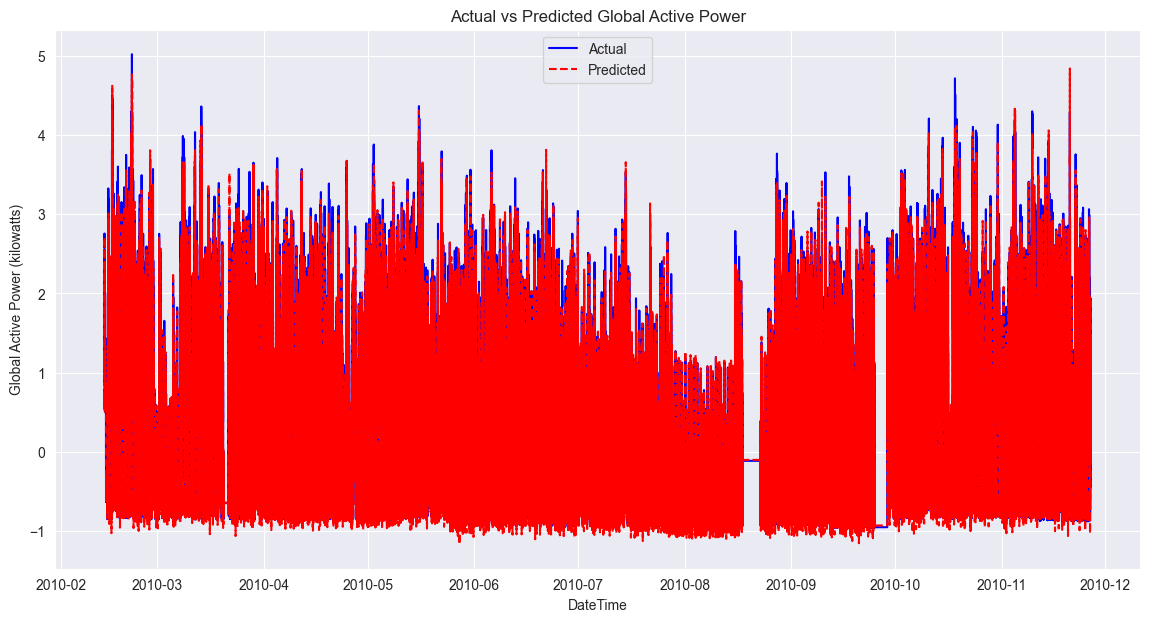

In [246]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Global Active Power')
plt.xlabel('DateTime')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()


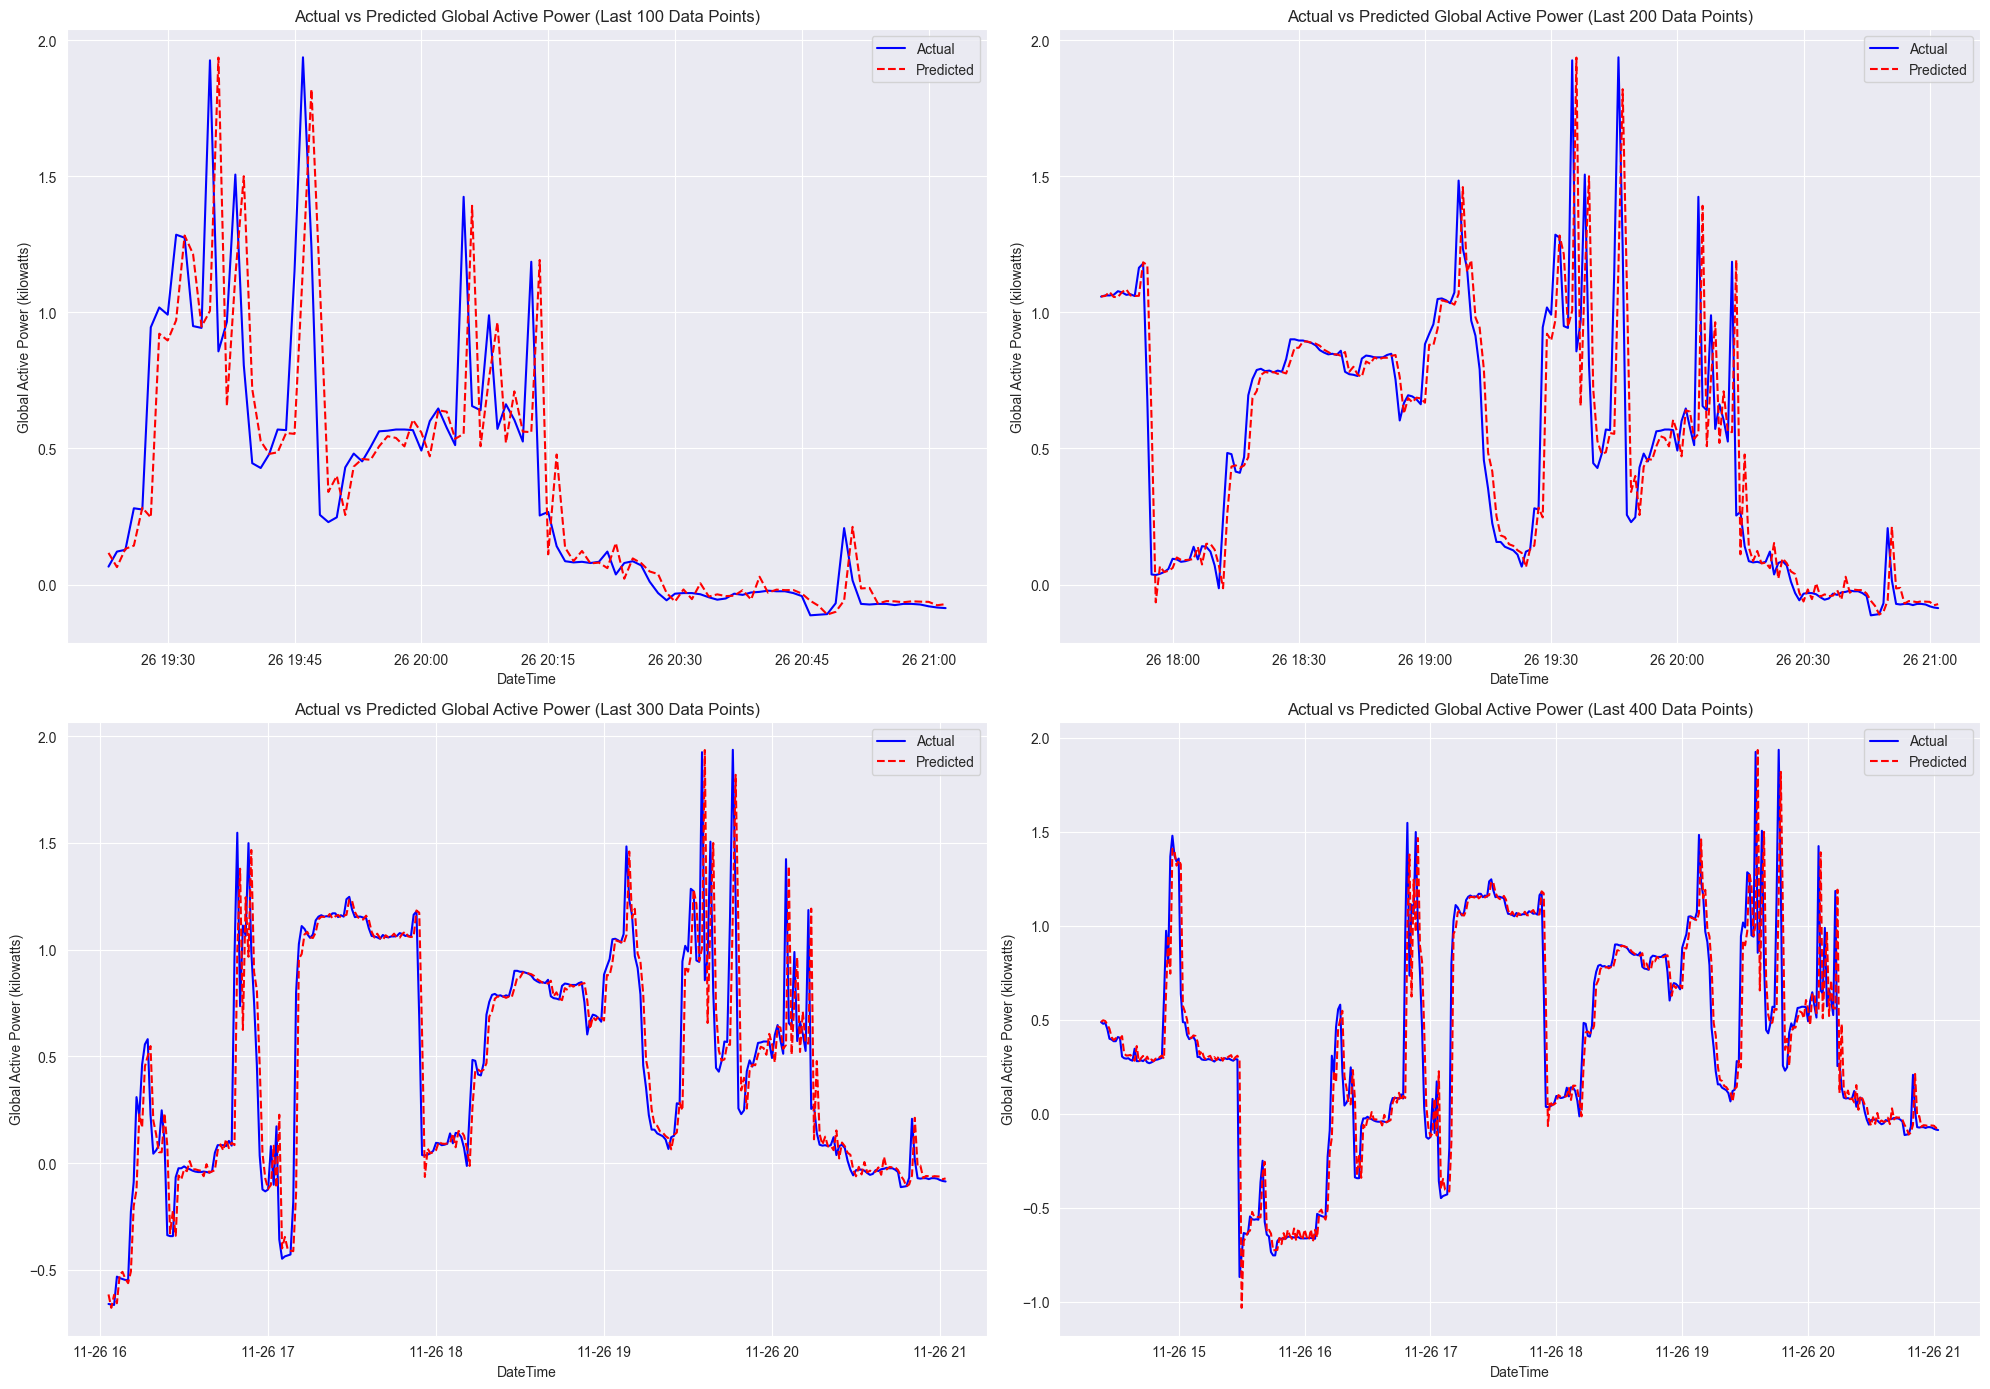

In [247]:
# Plot the actual vs predicted values for different time periods
time_periods = [100, 200, 300, 400]

fig2, axes2 = plt.subplots(2, 2, figsize=(20, 14))
axes2 = axes2.flatten()

for i, period in enumerate(time_periods):
    axes2[i].plot(y_test.index[-period:], y_test[-period:], label='Actual', color='blue')
    axes2[i].plot(y_test.index[-period:], y_pred[-period:], label='Predicted', color='red', linestyle='dashed')
    axes2[i].set_title(f'Actual vs Predicted Global Active Power (Last {period} Data Points)')
    axes2[i].set_xlabel('DateTime')
    axes2[i].set_ylabel('Global Active Power (kilowatts)')
    axes2[i].legend()

plt.tight_layout()
plt.show()

